# AI Powered Virtual Try On


### 1.1 Import the Libraries
Before we can use tools like MediaPipe to analyze images, we need to clean and organize the data. This step ensures that our data is in the correct format and ready for experiments.

In [1]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install opencv-python

  Using cached opencv_python-4.10.0.84-cp37-abi3-macosx_12_0_x86_64.whl.metadata (20 kB)
Using cached opencv_python-4.10.0.84-cp37-abi3-macosx_12_0_x86_64.whl (56.5 MB)
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install mediapipe

  Using cached mediapipe-0.10.18-cp312-cp312-macosx_11_0_x86_64.whl.metadata (9.7 kB)
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached flatbuffers-24.3.25-py2.py3-none-any.whl.metadata (850 bytes)
  Using cached jax-0.4.37-py3-none-any.whl.metadata (22 kB)
  Using cached jaxlib-0.4.36-cp312-cp312-macosx_10_14_x86_64.whl.metadata (1.0 kB)
  Using cached opencv_contrib_python-4.10.0.84-cp37-abi3-macosx_12_0_x86_64.whl.metadata (20 kB)
  Using cached sounddevice-0.5.1-py3-none-macosx_10_6_x86_64.macosx_10_6_universal2.whl.metadata (1.4 kB)
  Using cached sentencepiece-0.2.0-cp312-cp312-macosx_10_9_x86_64.whl.metadata (7.7 kB)
  Using cached ml_dtypes-0.5.0-cp312-cp312-macosx_10_9_universal2.whl.metadata (21 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
Using cached mediapipe-0.10.18-cp312-cp312-macosx_11_0_x86_64.whl (49.0 MB)
Using cached flatbuffers-24.3.25-py2.py3-none-any.whl (26 kB)
Using cached sounddevice-0.5.1-py3-none-macosx_

In [6]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [7]:
# Imports
import os
import cv2  # OpenCV for image processing
import numpy as np
import pandas as pd
from tqdm import tqdm
import mediapipe as mp 
import matplotlib.pyplot as plt

# Suppress warnings to keep output clean
import warnings
warnings.filterwarnings('ignore')

# Display progress bars
tqdm.pandas()

### 1.2 Load & Validate Data and Create Pairs Manually

Sometimes, the file containing image pairs (train_pairs.txt) needs manual formatting. We manually create a dataframe where each row corresponds to a pair of an image and a piece of clothing.

In [9]:
# Sample image pairs (manually formatted from train_pairs.txt)
image_cloth_pairs = [
    ("00577_00.jpg", "00024_00.jpg"),
    ("00018_00.jpg", "04879_00.jpg"),
    ("00025_00.jpg", "06990_00.jpg"),
    ("00023_00.jpg", "04608_00.jpg"),
    ("00009_00.jpg", "07274_00.jpg"),
    ("00000_00.jpg", "08733_00.jpg")
]

In [10]:
# Create a dataframe for pairs
data = pd.DataFrame(image_cloth_pairs, columns=["image", "cloth"])

# Show the dataframe
print("Manually created image-cloth pairs:")
print(data)


Manually created image-cloth pairs:
          image         cloth
0  00577_00.jpg  00024_00.jpg
1  00018_00.jpg  04879_00.jpg
2  00025_00.jpg  06990_00.jpg
3  00023_00.jpg  04608_00.jpg
4  00009_00.jpg  07274_00.jpg
5  00000_00.jpg  08733_00.jpg


### 1.3 Validate and Organize Files
Before preprocessing, ensure that all the required files are in their respective folders. If any file is missing, this step will alert us.


In [13]:
# Define the raw data folder paths
# Convert RAW_DATA_PATH to absolute path to avoid relative path issues
BASE_PATH = "/Users/quadrillionaiire/Documents/Phase-5-Capstone/AI-Powered-Virtual-Try-On"
RAW_DATA_PATH = os.path.join(BASE_PATH, "data/raw/train")
IMAGE_FOLDER = os.path.join(RAW_DATA_PATH, "image")  # Path to the image folder
CLOTH_FOLDER = os.path.join(RAW_DATA_PATH, "cloth")  # Path to the cloth folder

In [14]:
# Debugging: Print the resolved paths to ensure they are correct
print(f"Resolved Image Folder Path: {IMAGE_FOLDER}")
print(f"Resolved Cloth Folder Path: {CLOTH_FOLDER}")

Resolved Image Folder Path: /Users/quadrillionaiire/Documents/Phase-5-Capstone/AI-Powered-Virtual-Try-On/data/raw/train/image
Resolved Cloth Folder Path: /Users/quadrillionaiire/Documents/Phase-5-Capstone/AI-Powered-Virtual-Try-On/data/raw/train/cloth


In [17]:
 # Check for missing files
missing_files = []

for _, row in data.iterrows():
    image_path = os.path.join(IMAGE_FOLDER, row['image'])
    cloth_path = os.path.join(CLOTH_FOLDER, row['cloth'])

    if not os.path.exists(image_path):
        missing_files.append(image_path)
    if not os.path.exists(cloth_path):
        missing_files.append(cloth_path)

if missing_files:
    print("Missing files detected:", missing_files)
else:
    print("All files are present.")


All files are present.


### 2.1 Preprocess Images: Why Resize and Normalize?
To make all images uniform in size for analysis and to scale pixel values between 0 and 1 (normalization).

In [ ]:
# Define file paths
RAW_DATA_PATH = "/Users/quadrillionaiire/Documents/Phase-5-Capstone/AI-Powered-Virtual-Try-On/data/raw/train"
PROCESSED_DATA_PATH = "/Users/quadrillionaiire/Documents/Phase-5-Capstone/AI-Powered-Virtual-Try-On/data/processed"
IMAGE_FOLDER = os.path.join(RAW_DATA_PATH, "image")  # Folder containing raw images
CLOTH_FOLDER = os.path.join(RAW_DATA_PATH, "cloth")  # Folder containing raw clothing images
IMG_SIZE = (256, 192)  # Target dimensions for resizing images

In [ ]:
# Ensure the processed data directories exist
os.makedirs(os.path.join(PROCESSED_DATA_PATH, "image"), exist_ok=True)
os.makedirs(os.path.join(PROCESSED_DATA_PATH, "cloth"), exist_ok=True)

In [ ]:
# Function to preprocess images
def preprocess_image(image_path, output_folder, img_size):
    """
    Resize and normalize an image, then save it to the processed folder.
    
    Parameters:
        image_path (str): Path to the original image.
        output_folder (str): Path to the folder where processed images will be saved.
        img_size (tuple): Target size (width, height) for resizing the image.
    """
    # Load the image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Failed to load {image_path}")
        return

    # Resize the image
    img_resized = cv2.resize(img, img_size, interpolation=cv2.INTER_AREA)

    # Normalize the image (scale pixel values between 0 and 1)
    img_normalized = img_resized / 255.0

    # Determine the filename and output path
    filename = os.path.basename(image_path)  # Extract the filename from the original path
    output_path = os.path.join(output_folder, filename)  # Construct the output path

    # Save the processed image
    cv2.imwrite(output_path, (img_normalized * 255).astype(np.uint8))
    print(f"Processed and moved: {image_path} -> {output_path}")

#### Preprocess Function:

- Loads the image using OpenCV.
- Resizes the image to the specified dimensions.
- Normalizes pixel values to a range of 0–1.
- Constructs the output path using os.path.basename to retain the original filename.
- Saves the processed image in the processed folder.

In [22]:
# Ensure processed folders exist
os.makedirs(os.path.join(PROCESSED_DATA_PATH, "image"), exist_ok=True)
os.makedirs(os.path.join(PROCESSED_DATA_PATH, "cloth"), exist_ok=True)

In [23]:
# Preprocess each pair
# Function to preprocess images
def preprocess_image(image_path, output_path, img_size):
    """
    Resize and normalize an image, then save it.
    
    Parameters:
        image_path (str): Path to the original image.
        output_path (str): Path to save the processed image.
        img_size (tuple): Target size (width, height) for resizing.
    """
    # Load the image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Failed to load {image_path}")
        return

    # Resize the image
    img_resized = cv2.resize(img, img_size, interpolation=cv2.INTER_AREA)

    # Normalize the image (scale pixel values between 0 and 1)
    img_normalized = img_resized / 255.0

    # Save the processed image
    cv2.imwrite(output_path, (img_normalized * 255).astype(np.uint8))
    print(f"Processed and saved: {output_path}")

#### Processing Pairs
- The process_image_pairs function iterates over rows of the DataFrame using tqdm for progress tracking.
- Each row includes image and cloth file paths.
- Preprocessed files are saved in processed/image and processed/cloth.

### 3.1 Visualize Processed Images  
It's always good to visually check a few processed images to ensure they look correct.

In [24]:
# Function to plot images for visualization
def plot_images(image_paths, titles, ncols=3):
    """
    Display multiple images in a grid format.

    Parameters:
        image_paths (list): List of paths to the images to display.
        titles (list): List of titles corresponding to each image.
        ncols (int): Number of columns in the grid.
    """
    nrows = int(np.ceil(len(image_paths) / ncols))  # Calculate rows based on total images
    plt.figure(figsize=(15, 5 * nrows))
    for i, (img_path, title) in enumerate(zip(image_paths, titles)):
        img = cv2.imread(img_path)  # Read the image
        if img is not None:
            plt.subplot(nrows, ncols, i + 1)
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
            plt.title(title)  # Set the title for each image
            plt.axis('off')  # Hide axes
    plt.show()

The plot_images function displays images in a grid for inspection.


In [ ]:
# # Example visualization
# sample_images = data.sample(3)
# image_paths = [os.path.join(PROCESSED_DATA_PATH, "image", img) for img in sample_images["image"]]
# cloth_paths = [os.path.join(PROCESSED_DATA_PATH, "cloth", cloth) for cloth in sample_images["cloth"]]
# plot_images(image_paths + cloth_paths, ["Image"] * 3 + ["Cloth"] * 3)

In [25]:
# Main processing script
def process_image_pairs(data, image_folder, cloth_folder, processed_folder, img_size):
    """
    Preprocess image and cloth pairs and save them to the processed folder.

    Parameters:
        data (DataFrame): DataFrame containing 'image' and 'cloth' column paths.
        image_folder (str): Path to raw image folder.
        cloth_folder (str): Path to raw cloth folder.
        processed_folder (str): Path to save processed images.
        img_size (tuple): Target size (width, height) for resizing images.
    """
    # Iterate through each row in the DataFrame
    for _, row in tqdm(data.iterrows(), total=len(data), desc="Processing image pairs"):
        # Get raw image and cloth paths
        img_path = os.path.join(image_folder, row['image'])
        cloth_path = os.path.join(cloth_folder, row['cloth'])

        # Define output paths for processed files
        processed_img_path = os.path.join(processed_folder, "image", row['image'])
        processed_cloth_path = os.path.join(processed_folder, "cloth", row['cloth'])

        # Preprocess and save images
        preprocess_image(img_path, processed_img_path, img_size)
        preprocess_image(cloth_path, processed_cloth_path, img_size)

Processing image pairs: 100%|██████████| 6/6 [00:00<00:00, 65.65it/s]


Processed and saved: /Users/quadrillionaiire/Documents/Phase-5-Capstone/AI-Powered-Virtual-Try-On/data/processed/image/00577_00.jpg
Processed and saved: /Users/quadrillionaiire/Documents/Phase-5-Capstone/AI-Powered-Virtual-Try-On/data/processed/cloth/00024_00.jpg
Processed and saved: /Users/quadrillionaiire/Documents/Phase-5-Capstone/AI-Powered-Virtual-Try-On/data/processed/image/00018_00.jpg
Processed and saved: /Users/quadrillionaiire/Documents/Phase-5-Capstone/AI-Powered-Virtual-Try-On/data/processed/cloth/04879_00.jpg
Processed and saved: /Users/quadrillionaiire/Documents/Phase-5-Capstone/AI-Powered-Virtual-Try-On/data/processed/image/00025_00.jpg
Processed and saved: /Users/quadrillionaiire/Documents/Phase-5-Capstone/AI-Powered-Virtual-Try-On/data/processed/cloth/06990_00.jpg
Processed and saved: /Users/quadrillionaiire/Documents/Phase-5-Capstone/AI-Powered-Virtual-Try-On/data/processed/image/00023_00.jpg
Processed and saved: /Users/quadrillionaiire/Documents/Phase-5-Capstone/AI-P

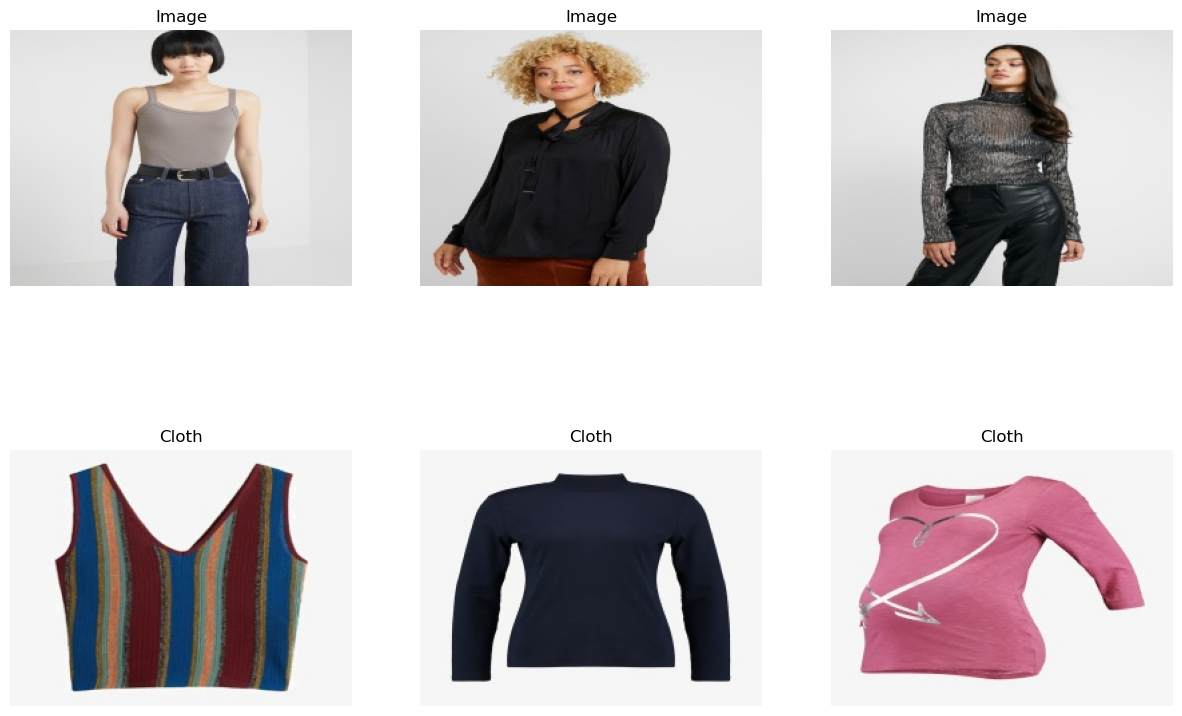

In [26]:
#Run the processing function
process_image_pairs(data, IMAGE_FOLDER, CLOTH_FOLDER, PROCESSED_DATA_PATH, IMG_SIZE)

# Visualize a few processed images
sample_images = data.sample(3)  # Randomly sample 3 pairs
image_paths = [os.path.join(PROCESSED_DATA_PATH, "image", img) for img in sample_images["image"]]
cloth_paths = [os.path.join(PROCESSED_DATA_PATH, "cloth", cloth) for cloth in sample_images["cloth"]]

# Plot images and cloths for inspection
plot_images(image_paths + cloth_paths, ["Image"] * len(image_paths) + ["Cloth"] * len(cloth_paths))

### 3.2 Experiment with MediaPipe
MediaPipe helps analyze pose and other features from images. This step involves loading preprocessed images and running them through MediaPipe for pose detection.

In [27]:
# Initialize MediaPipe pose detector
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()

I0000 00:00:1734012584.703632  478051 gl_context.cc:357] GL version: 2.1 (2.1 ATI-6.1.13), renderer: AMD Radeon Pro 5300M OpenGL Engine


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1734012584.858755  507512 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1734012584.888559  507512 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [ ]:
# Function to run MediaPipe on an image
def run_mediapipe_on_image(image_path):
    """
    Detect poses using MediaPipe and display key points.

    Parameters:
        image_path (str): Path to the input image.
    """
    img = cv2.imread(image_path)  # Load the image
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for MediaPipe

    # Process the image to detect poses
    results = pose.process(img_rgb)

    # Draw key points on the image
    annotated_image = img.copy()
    if results.pose_landmarks:
        mp.solutions.drawing_utils.draw_landmarks(
            annotated_image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS
        )

    # Display the annotated image
    plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

W0000 00:00:1734012691.488480  507518 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


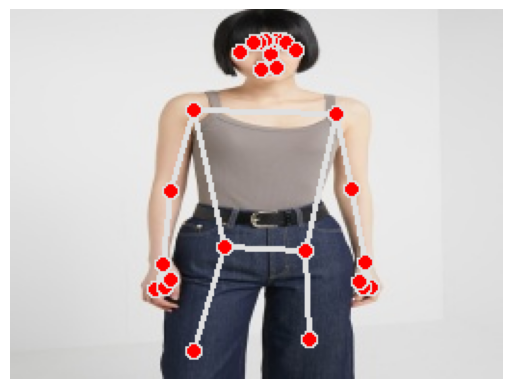

In [29]:
# Example: Run MediaPipe on one image
run_mediapipe_on_image(os.path.join(PROCESSED_DATA_PATH, "image", data.iloc[0]['image']))

### 3.3 Overlaying the Clothes 
Using the pose landmarks, we position the clothing image on the body.

In [30]:
from PIL import Image

def overlay_clothing(pose_image_path, clothing_image_path, position=(100, 100)):
    """
    Overlay clothing onto the pose image.

    Parameters:
        pose_image_path (str): Path to the pose image.
        clothing_image_path (str): Path to the clothing image.
        position (tuple): Position to overlay the clothing on the image.
    """
    pose_image = Image.open(pose_image_path).convert("RGBA")
    clothing_image = Image.open(clothing_image_path).convert("RGBA")

    # Resize clothing to match target region (hardcoded for simplicity)
    clothing_resized = clothing_image.resize((100, 150))

    # Overlay the clothing onto the pose image
    pose_image.paste(clothing_resized, position, clothing_resized)
    return pose_image


### 4. Notes and Future Steps
- Clothing Alignment: Use pose landmarks (e.g., shoulder, hip) to dynamically position and resize the clothing image.
- Deep Learning Integration: Refine clothing fit using pre-trained models (like U-Net) to warp the clothing item.